In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [25]:
data = pd.read_csv('apartments_for_rent_classified_100K.csv', sep=";", encoding='cp1252')

C:\Users\baran\AppData\Local\Temp\ipykernel_16952\1045290674.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('apartments_for_rent_classified_100K.csv', sep=";", encoding='cp1252')


In [26]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
data['bathrooms'] = imputer.fit_transform(data[['bathrooms']])
data['bedrooms'] = imputer.fit_transform(data[['bedrooms']])
data['square_feet'] = imputer.fit_transform(data[['square_feet']])
#ortalamanın değerini verir
#remove time id and adress columns
data.drop(['id', 'title', 'body', 'address', 'time','price_display'], axis=1)


,category,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_type,square_feet,cityname,state,latitude,longitude,source
0,housing/rent/apartment,NaN,1.0,1.0,USD,No,Thumbnail,Cats,2195.0,Monthly,542.0,Redondo Beach,CA,33.8520,-118.3759,RentLingo
1,housing/rent/apartment,NaN,1.5,3.0,USD,No,Thumbnail,"Cats,Dogs",1250.0,Monthly,1500.0,Newport News,VA,37.0867,-76.4941,RentLingo
2,housing/rent/apartment,NaN,2.0,3.0,USD,No,Thumbnail,NaN,1395.0,Monthly,1650.0,Raleigh,NC,35.8230,-78.6438,RentLingo
3,housing/rent/apartment,NaN,1.0,2.0,USD,No,Thumbnail,"Cats,Dogs",1600.0,Monthly,820.0,Vacaville,CA,38.3622,-121.9712,RentLingo
4,housing/rent/apartment,NaN,1.0,1.0,USD,No,Thumbnail,"Cats,Dogs",975.0,Monthly,624.0,Albuquerque,NM,35.1038,-106.6110,RentLingo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99487,housing/rent/apartment,"Gym,Parking,Patio/Deck,Playground,Storage,Wood...",1.0,1.0,USD,No,Yes,NaN,780.0,Monthly,605.0,Houston,TX,29.6151,-95.1998,RentDigs.com
99488,housing/rent/apartment,"AC,Cable or Satellite,Clubhouse,Dishwasher,Gym...",2.0,2.0,USD,No,Yes,"Cats,Dogs",813.0,Monthly,921.0,Jacksonville,FL,30.2254,-81.7579,RentDigs.com
99489,housing/rent/apartment,"Garbage Disposal,Refrigerator",1.0,1.0,USD,No,Yes,"Cats,Dogs",1325.0,Monthly,650.0,San Diego,CA,32.7379,-117.0914,RentDigs.com
99490,housing/rent/apartment,"Gym,Pool",1.0,1.0,USD,No,Yes,"Cats,Dogs",931.0,Monthly,701.0,Huntersville,NC,35.4158,-80.8451,RentDigs.com


In [27]:
amenities = data['amenities'].str.get_dummies(sep=',')
data = pd.concat([data, amenities], axis=1)
data = data.drop(columns=['amenities'])
data



,id,category,title,body,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,...,Patio/Deck,Playground,Pool,Refrigerator,Storage,TV,Tennis,View,Washer Dryer,Wood Floors
0,5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",1.0,1.0,USD,No,Thumbnail,Cats,...,0,0,0,0,0,0,0,0,0,0
1,5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",1.5,3.0,USD,No,Thumbnail,"Cats,Dogs",...,0,0,0,0,0,0,0,0,0,0
2,5668639686,housing/rent/apartment,Three BR 3101 Morningside Drive,This unit is located at 3101 Morningside Drive...,2.0,3.0,USD,No,Thumbnail,NaN,...,0,0,0,0,0,0,0,0,0,0
3,5668639659,housing/rent/apartment,Two BR 209 Aegean Way,"This unit is located at 209 Aegean Way, Vacavi...",1.0,2.0,USD,No,Thumbnail,"Cats,Dogs",...,0,0,0,0,0,0,0,0,0,0
4,5668639374,housing/rent/apartment,One BR 4805 Marquette NE,"This unit is located at 4805 Marquette NE, Alb...",1.0,1.0,USD,No,Thumbnail,"Cats,Dogs",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99487,5121219946,housing/rent/apartment,Houston - superb Apartment nearby fine dining,"Redefining urban living, in southeast Houston,...",1.0,1.0,USD,No,Yes,NaN,...,1,1,0,0,1,0,0,0,0,1
99488,5121219696,housing/rent/apartment,The Best of the Best in the City of Jacksonvil...,Courtney Manor Apartments offer the best of ev...,2.0,2.0,USD,No,Yes,"Cats,Dogs",...,1,1,1,1,1,1,0,0,1,0
99489,5121219420,housing/rent/apartment,A great & large One BR apartment. Pet OK!,"Fully remodeled, new floor, kitchen cabinet, s...",1.0,1.0,USD,No,Yes,"Cats,Dogs",...,0,0,0,1,0,0,0,0,0,0
99490,5121218935,housing/rent/apartment,"The Crest offers studio, 1, 2 & Three BR homes...","Amenities include a fitness facilities, swimmi...",1.0,1.0,USD,No,Yes,"Cats,Dogs",...,0,0,1,0,0,0,0,0,0,0


<Axes: >

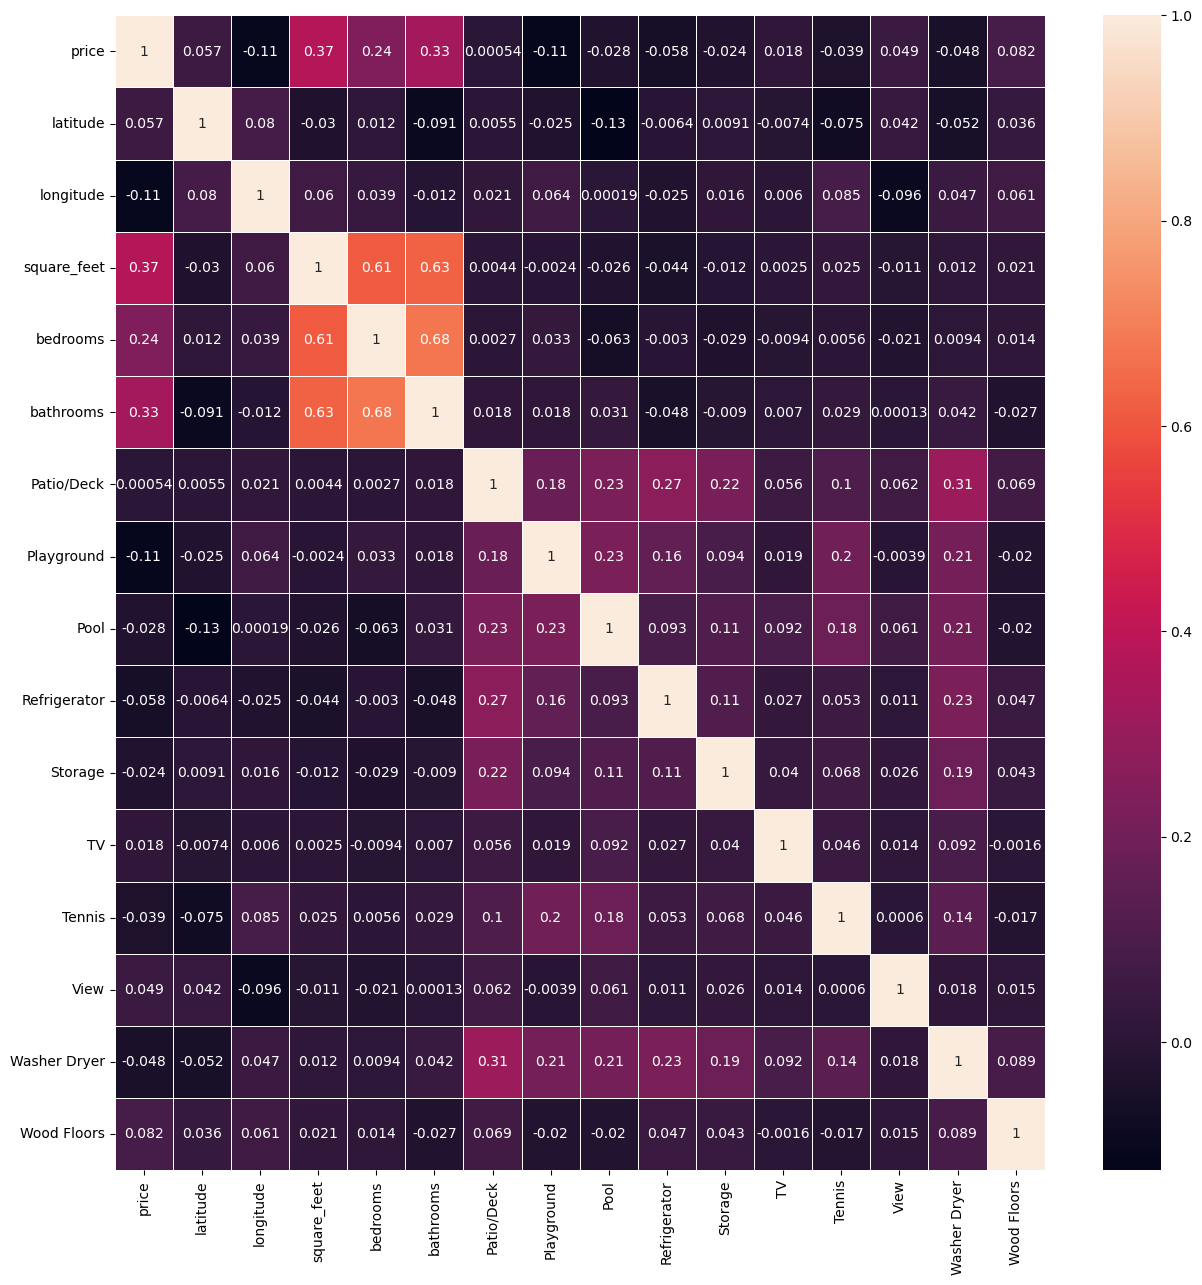

In [33]:
corr = data[['price', 'latitude', 'longitude', 'square_feet', 'bedrooms', 'bathrooms', 'Patio/Deck', 'Playground', 'Pool', 'Refrigerator', 'Storage', 'TV', 'Tennis', 'View', 'Washer Dryer', 'Wood Floors']].corr()
corr
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
#heatmap with small text
sns.heatmap(corr, annot=True,linewidths=.5, ax=ax)

In [ ]:
#remove category column
data = data.drop(columns=['title','body','time','price_display','currency',])



In [42]:
X = data.drop(['price'], axis=1)
y = data['price']

# Scale the numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)


ValueError: could not convert string to float: 'USD'